In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

import spacy

import matplotlib.pyplot as pyplot
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
df=pd.read_csv('got_scripts_breakdown.csv', sep=';')
df.head()

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [4]:
# Convert to list
data = df.Sentence.values.tolist()

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each', 'other', 'to', 'pieces']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each_other', 'to', 'pieces']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['expect', 'savage', 'lot', 'steal', 'goat', 'lot', 'know', 'rip', 'piece']]


In [8]:
# train model
model2 = gensim.models.Word2Vec(
        data_lemmatized,
        window=10,
        min_count=2,
        workers=10,
        iter=10,
        size=300)
#print(model2)
words2 = list(model2.wv.vocab)
#print(words2[:100])
#print(model2['winter'])

In [9]:
model2.wv.most_similar(positive=["dragon"])

[('auction', 0.9829524159431458),
 ('grass', 0.9807100296020508),
 ('breaker', 0.9805734157562256),
 ('old', 0.9805631637573242),
 ('life', 0.9789410829544067),
 ('valyria', 0.9740142226219177),
 ('year', 0.9730652570724487),
 ('burn', 0.9728043675422668),
 ('chain', 0.9722097516059875),
 ('thousand', 0.9717590808868408)]

perplexicity = 40, iteration = 250

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


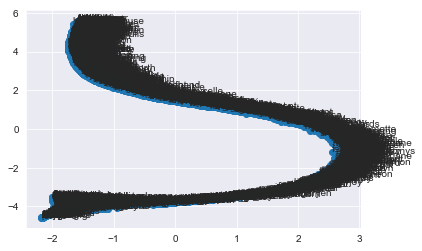

In [11]:
data_subset = model2[model2.wv.vocab]
# pca = PCA(n_components=50)
# pca_result_50 = pca.fit_transform(data_subset)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250, random_state=2)
tsne_pca_results = tsne.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results[:, 0], tsne_pca_results[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results[i, 0], tsne_pca_results[i, 1]))
pyplot.show()

perplexicity = 20, iteration = 250

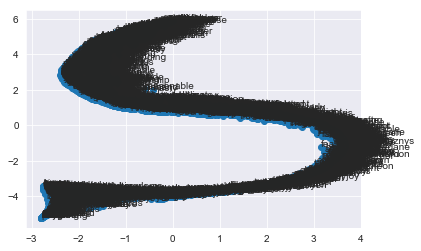

In [12]:
tsne_p_20 = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=250, random_state=2)
tsne_pca_results_p_20 = tsne_p_20.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_p_20[:, 0], tsne_pca_results_p_20[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_p_20[i, 0], tsne_pca_results_p_20[i, 1]))
pyplot.show()

perplexicity = 60, iteration = 250

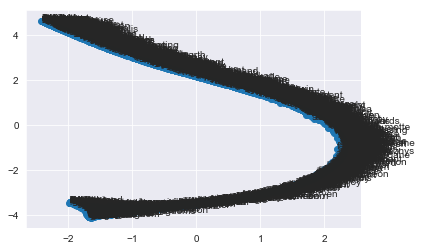

In [13]:
tsne_p_60 = TSNE(n_components=2, verbose=0, perplexity=60, n_iter=250, random_state=2)
tsne_pca_results_p_60 = tsne_p_60.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_p_60[:, 0], tsne_pca_results_p_60[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_p_60[i, 0], tsne_pca_results_p_60[i, 1]))
pyplot.show()

perplexicity = 100, iteration = 250

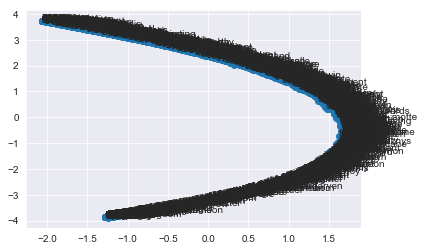

In [14]:
tsne_p_100 = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=250, random_state=2)
tsne_pca_results_p_100 = tsne_p_100.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_p_100[:, 0], tsne_pca_results_p_100[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_p_100[i, 0], tsne_pca_results_p_100[i, 1]))
pyplot.show()

perplexicity = 5, iteration = 250

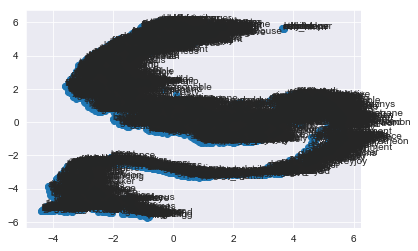

In [15]:
tsne_p_5 = TSNE(n_components=2, verbose=0, perplexity=5, n_iter=250, random_state=2)
tsne_pca_results_p_5 = tsne_p_5.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_p_5[:, 0], tsne_pca_results_p_5[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_p_5[i, 0], tsne_pca_results_p_5[i, 1]))
pyplot.show()

perplexicity = 40, iteration = 500

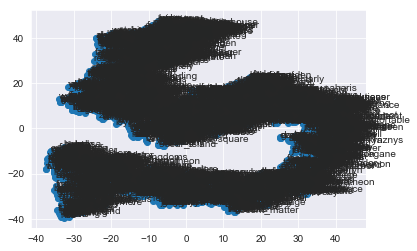

In [16]:
tsne_i_500 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500, random_state=2)
tsne_pca_results_i_500 = tsne_i_500.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_i_500[:, 0], tsne_pca_results_i_500[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_i_500[i, 0], tsne_pca_results_i_500[i, 1]))
pyplot.show()

perplexicity = 40, iteration = 1000

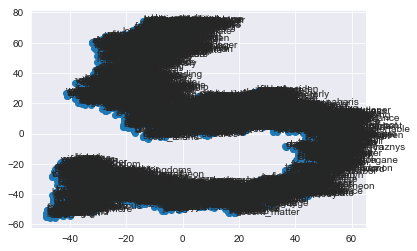

In [17]:
tsne_i_1000 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000, random_state=2)
tsne_pca_results_i_1000 = tsne_i_1000.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_i_1000[:, 0], tsne_pca_results_i_1000[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_i_1000[i, 0], tsne_pca_results_i_1000[i, 1]))
pyplot.show()

perplexicity = 40, iteration = 2000

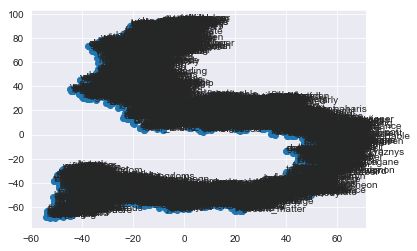

In [18]:
tsne_i_2000 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=2000, random_state=2)
tsne_pca_results_i_2000 = tsne_i_2000.fit_transform(data_subset)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results_i_2000[:, 0], tsne_pca_results_i_2000[:, 1])
words2 = list(model2.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results_i_2000[i, 0], tsne_pca_results_i_2000[i, 1]))
pyplot.show()

changed size (dimentionality of vectors) from 300 to 200

In [19]:
# train model
model1 = gensim.models.Word2Vec(
        data_lemmatized,
        window=10,
        min_count=2,
        workers=10,
        iter=10,
        size=200)
#print(model2)
words1 = list(model1.wv.vocab)
#print(words2[:100])
#print(model2['winter'])

In [11]:
model1.wv.most_similar(positive=["dragon"])

[('grass', 0.978352427482605),
 ('old', 0.9703589081764221),
 ('unhurt', 0.9697825908660889),
 ('khaleesi', 0.9694440364837646),
 ('breaker', 0.9694122076034546),
 ('live', 0.9665603041648865),
 ('chain', 0.964057445526123),
 ('gift', 0.9604912996292114),
 ('remake', 0.960460901260376),
 ('year', 0.9604253768920898)]

perplexicity = 40, iteration = 250

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


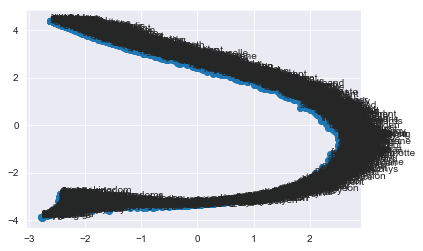

In [20]:
data_subset1 = model1[model1.wv.vocab]

tsne1 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250, random_state=2)
tsne_pca_results1 = tsne1.fit_transform(data_subset1)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results1[:, 0], tsne_pca_results1[:, 1])
words1 = list(model1.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results1[i, 0], tsne_pca_results1[i, 1]))
pyplot.show()

perplexicity = 40, iteration = 2000

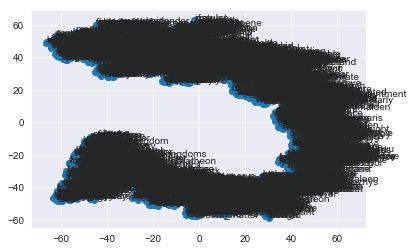

In [23]:
tsne1_i_2000 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=2000, random_state=2)
tsne_pca_results1_i_2000 = tsne1_i_2000.fit_transform(data_subset1)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results1_i_2000[:, 0], tsne_pca_results1_i_2000[:, 1])
words1 = list(model1.wv.vocab)
for i, word in enumerate(words2):
    pyplot.annotate(word, xy=(tsne_pca_results1_i_2000[i, 0], tsne_pca_results1_i_2000[i, 1]))
pyplot.show()

changed window size from 10 to 5

In [24]:
# train model
model3 = gensim.models.Word2Vec(
        data_lemmatized,
        window=5,
        min_count=2,
        workers=10,
        iter=10,
        size=300)
#print(model2)

data_subset3 = model3[model3.wv.vocab]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [13]:
model3.wv.most_similar(positive=["dragon"])

[('breaker', 0.9886287450790405),
 ('slave', 0.9838590025901794),
 ('unhurt', 0.9834072589874268),
 ('rape', 0.9818825125694275),
 ('chain', 0.9812922477722168),
 ('khaleesi', 0.9812190532684326),
 ('unsullied', 0.9807580709457397),
 ('treasure', 0.9805526733398438),
 ('enslave', 0.980522632598877),
 ('old', 0.9801062345504761)]

perplexicity = 40, iteration = 250

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


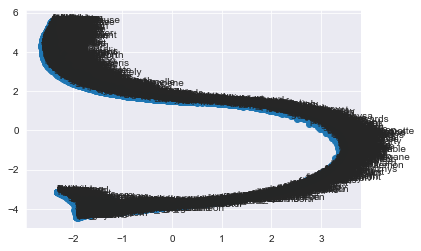

In [25]:
data_subset3 = model3[model3.wv.vocab]

tsne3 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250, random_state=2)
tsne_pca_results3 = tsne3.fit_transform(data_subset3)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results3[:, 0], tsne_pca_results3[:, 1])
words3 = list(model3.wv.vocab)
for i, word in enumerate(words3):
    pyplot.annotate(word, xy=(tsne_pca_results3[i, 0], tsne_pca_results3[i, 1]))
pyplot.show()

changed the default alpha value from 0.025 to 0.3

In [26]:
# train model
model4 = gensim.models.Word2Vec(
        data_lemmatized,
        window=10,
        min_count=2,
        workers=10,
        iter=10,
        size=300,
        alpha=0.03, 
        min_alpha=0.0007)
#print(model2)
words4 = list(model4.wv.vocab)

In [16]:
model4.wv.most_similar(positive=["dragon"])

[('unhurt', 0.9605699181556702),
 ('breaker', 0.897087574005127),
 ('auction', 0.8957569003105164),
 ('khaleesi', 0.8919020891189575),
 ('grass', 0.8884686827659607),
 ('live', 0.8875910043716431),
 ('life', 0.8816713094711304),
 ('fire', 0.8806646466255188),
 ('chain', 0.876688539981842),
 ('slave', 0.8738246560096741)]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


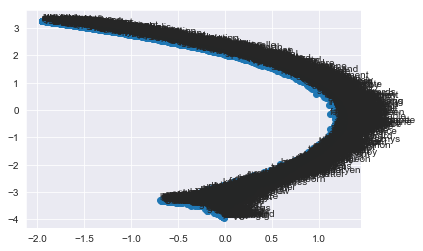

In [27]:
data_subset4 = model4[model4.wv.vocab]

tsne4 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250, random_state=2)
tsne_pca_results4 = tsne3.fit_transform(data_subset4)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results4[:, 0], tsne_pca_results4[:, 1])
words4 = list(model4.wv.vocab)
for i, word in enumerate(words4):
    pyplot.annotate(word, xy=(tsne_pca_results4[i, 0], tsne_pca_results4[i, 1]))
pyplot.show()

In [18]:
# train model
model5 = gensim.models.Word2Vec(
        data_lemmatized,
        window=5,
        min_count=5,
        workers=10,
        iter=10,
        size=300)
#print(model2)

data_subset5 = model5[model5.wv.vocab]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [19]:
model5.wv.most_similar(positive=["dragon"])

[('live', 0.9791992902755737),
 ('slave', 0.9774371385574341),
 ('khaleesi', 0.9768544435501099),
 ('build', 0.9757845997810364),
 ('breaker', 0.9754997491836548),
 ('chain', 0.9746544361114502),
 ('grass', 0.9733821153640747),
 ('rich', 0.9719484448432922),
 ('death', 0.9713637828826904),
 ('rhaegar', 0.969560980796814)]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


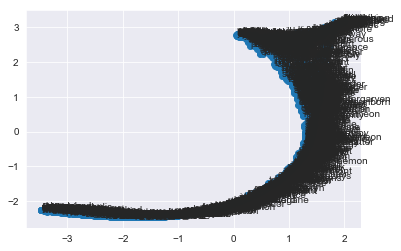

In [14]:
data_subset5 = model5[model5.wv.vocab]

tsne5 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250)
tsne_pca_results5 = tsne5.fit_transform(data_subset5)
# create a scatter plot of the projection


pyplot.scatter(tsne_pca_results5[:, 0], tsne_pca_results5[:, 1])
words5 = list(model5.wv.vocab)
for i, word in enumerate(words5):
    pyplot.annotate(word, xy=(tsne_pca_results5[i, 0], tsne_pca_results5[i, 1]))
pyplot.show()